In [2]:
from promisces import *
import numpy as np

# Getting started

`promisces` exposes classes and objects with which you can configure simulations.

## known entities

`Substances`, `Matrices` and `Treatments` are objects whose attributes refer to (from `promisces`) known `Substance`, `Matrix` and `Treatment` (respectively).
For example, 
- `Matrices.rww` returns a `Matrix` instance corresponding to "raw wastewater"
- `Substances.pfoa` returns a `Substance` instance corresponding to "Perfluorooctanoic acid"

## configurable entities

There are several classes exposed by `promisces` with which you can configure the remaining parameters of a simulation. The most important are:

1. `StartingConcentration(array: np.ndarray, substance: Substance, matrix: Matrix)` where the values in `array` are in ng / L.
2. `TreatmentTrain(treatments: list[Treatment, ...])` for defining the treatment train of the simulation.

## example simulation

### inputs

The next cell configures and runs an example simulation. The function `simulate_removal()` takes the following input arguments:

```
treatment_train: TreatmentTrain,
substance: Substance,
input_matrix: Matrix,
n_runs: int = 10000,
    # the number of removal factors to simulate at each steps
rmv_factor_resolution: int = 1000,
    # removal factors will be drawn between 1/rmv_factor_resolution and 1 - 1/rmv_factor_resolution
```

the last three arguments to `simulate_removal()`

```
case_study: Optional[CaseStudy] = None,
reference: Reference | None = None,
scenario: str = ""
```

are optional. They allow you to provide custom data to the simulation.

> Note that, by default, `simulate_removal()` uses only literature data for building a probability distribution of the removal factor for a given treatment.

### outputs

The object returned by `simulate_removal()` is an instance of `SimulationResult` and allows you to access various informations about the simulation, as well as exporting a summary to excel.

- `result.output_c_df`: a `pandas.DataFrame` of the estimated output concentrations of `substance` after each treatment.
- `result.rmv_factor_df`: a `pandas.DataFrame` of the drawn removal factors at each treatment step.
- `result.treatment_df`: a `pandas.DataFrame` summarizing the treatments.
- `result.export_excel(filename)` a method to write statistical descriptions of `output_c_df` and `rmv_factor_df` as well as `treatments_df` into an excel file with name `filename`.

Those are demonstrated in the cells following the next cell.

### ER profiles

To plot the ER profiles of the result, simply do

```
er_profiles(result)
```

if you provide a path through the `save_as` argument, the plot will be saved at this path. Eg

```
er_profiles(result, save_as="example-profile.png")
```




In [5]:
substance = Substances.pfoa
input_matrix = Matrices.rww

start_c = StartingConcentration(
    np.array([100]),
    substance, matrix
)

treatment_train = TreatmentTrain([
    Treatments.wwtt,
    Treatments.wwco,
    Treatments.dwae,
    Treatments.dwrf,
    Treatments.dwac,
])

result = simulate_removal(
    treatment_train,
    substance,
    input_matrix,
    n_runs = 10_000,
    rmv_factor_resolution = 1000
)

In [6]:
result.output_c_df

,input,wwtt,wwco,dwae,dwrf,dwac
0,549.945241,2.172233,176.878232,176.701354,176.524653,176.348128
1,549.913342,2.217173,176.876553,176.699676,176.522977,176.346454
2,549.852642,2.239586,176.876100,176.699224,176.522525,176.346002
3,549.838400,2.351704,176.833057,176.656224,176.479567,176.303088
4,549.777792,2.464574,176.796526,176.619730,176.443110,176.266667
...,...,...,...,...,...,...
9995,2.467041,0.549778,0.480255,0.438473,0.074102,0.000074
9996,2.354058,0.549838,0.479642,0.437913,0.067876,0.000068
9997,2.241828,0.549853,0.478534,0.436423,0.064154,0.000064
9998,2.219392,0.549913,0.476906,0.434461,0.002607,0.000003


In [7]:
result.rmv_factor_df

,wwtt,wwco,dwae,dwrf,dwac
0,0.1,0.1,0.1,0.1,0.1
1,0.1,0.1,0.1,0.1,0.1
2,0.1,0.1,0.1,0.1,0.1
3,0.1,0.1,0.1,0.1,0.1
4,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...
9995,99.9,10.3,8.7,83.1,99.9
9996,99.9,10.4,8.7,84.5,99.9
9997,99.9,10.6,8.8,85.3,99.9
9998,99.9,10.9,8.9,99.4,99.9


In [8]:
result.treatment_df

,treatment_id,average_out,input_matrix,output_matrix,dominant_data,substance,n_runs,removal_factor_resolution
0,wwtt,False,Raw wastewater,Treated wastewater,Literature,Perfluorooctanoic acid,10000,1000
1,wwco,False,Treated wastewater,Treated wastewater,Literature,Perfluorooctanoic acid,10000,1000
2,dwae,False,Treated wastewater,Drinking water,Combination,Perfluorooctanoic acid,10000,1000
3,dwrf,False,Drinking water,Drinking water,Combination,Perfluorooctanoic acid,10000,1000
4,dwac,False,Drinking water,Drinking water,Prior,Perfluorooctanoic acid,10000,1000


In [6]:
result.export_excel("example-simulation.xlsx")

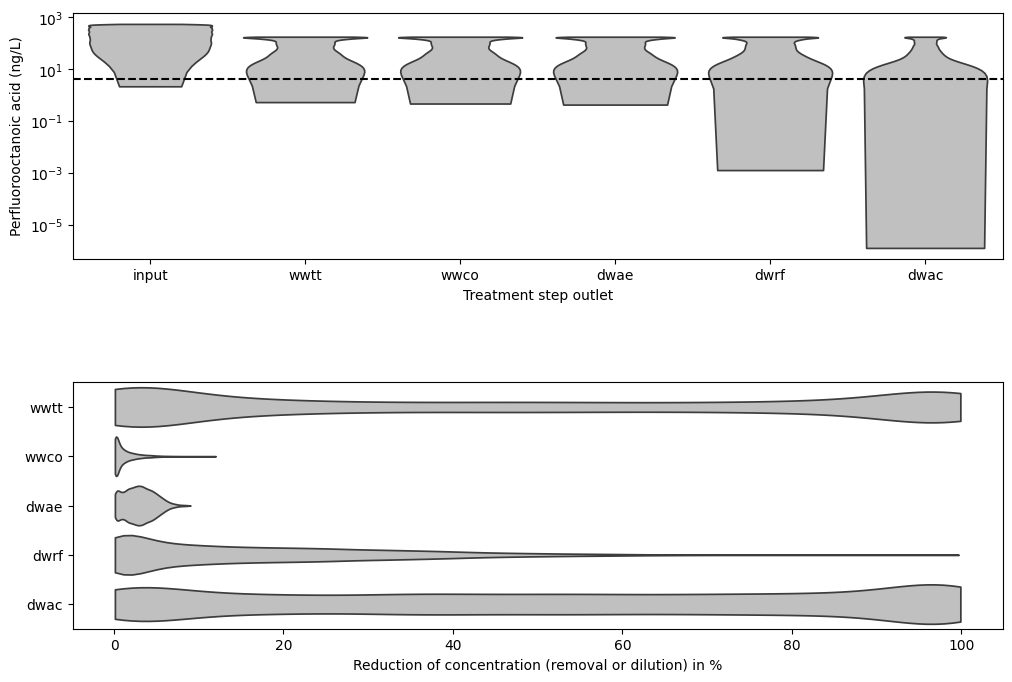

In [9]:
er_profiles(result)
None

## `CaseStudy`

with the `CaseStudy` class, you can 
- define specific `RemovalPercent` for given `treatment` and `substance`.
- define `Mixture` parameters for mixing and separation treatments.
- define `StartingConcentration` for a `substance` and a `matrix`
- provide `Reference` values used for plotting ER profiles

The case studies defined in `promisces/models/case_study.py` will show you examples.

If you provide a `CaseStudy` instance to `simulate_removal` through the `case_study` argument, the simulation will extract relevant data from the case study and use it:
- if the `CaseStudy` contains a matching `StartingConcentration`, it will be used instead of literature data.
- if the `CaseStudy` contains matching `RemovalPercent`s, those will be used in combination with the ones available in the literature.

> Note that providing a `CaseStudy` to `simulate_removal()` is the only way to specify `Mixture` parameters for mixing and separation treatments.

> Note also that you can assign `Mixture` definition to various `scenario` within the case study.


the following cell shows you how to define and use a `CaseStudy` to run simulations with different scenari and do a `spider_plot` of all the runs.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.71922038 0.77258464 0.52550177 0.73321999 0.66951874 0.78293462
 0.8346784  0.6469983  0.74625881 0.69804677 0.74750464 0.46817992
 0.68473082 0.81917109 0.68025354 0.68967496 0.57249751 0.75403158
 0.66784566 0.58709826]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[14.61979553 12.44506284  7.39196295  9.12163599 14.00239939  5.41219062
  8.28353824 13.52946191  8.14192483 16.82422893 13.93445292  8.07931001
 11.95655739  5.61917333 14.10363535 10.24010989 15.76823377  9.87558598
  5.91881738  7.92363601]
[0.71968748 0.86708755 0.68835567 0.85902321 0.49267383 0.68287088
 0.5746307  0.69267091 0.66486733 0.62219622 0.73474751 0.55364272
 0.85787096 0.66790145 0.55890279 0.45845101 0.77088001 0.55031419
 0.74733952 0.66207132]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.89070077 0.77402869 0.858221   0.92793359 0.97803433 0.78145673
 0.97387234 0.98765819 0.82282324 0.87770398 0.9615442  0.85633797
 0.

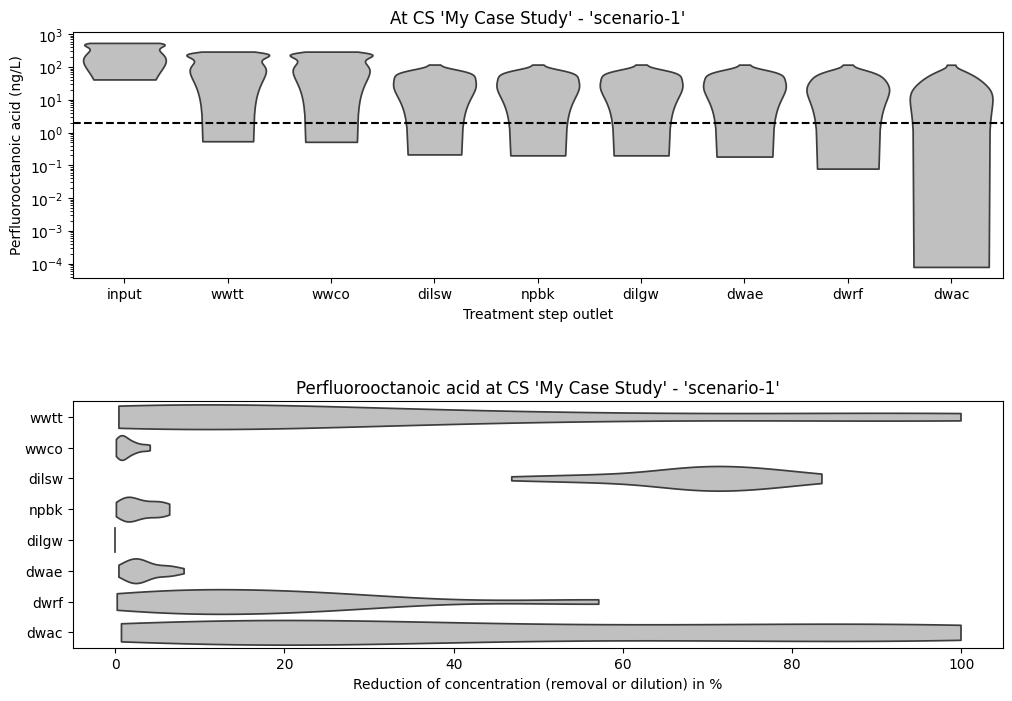

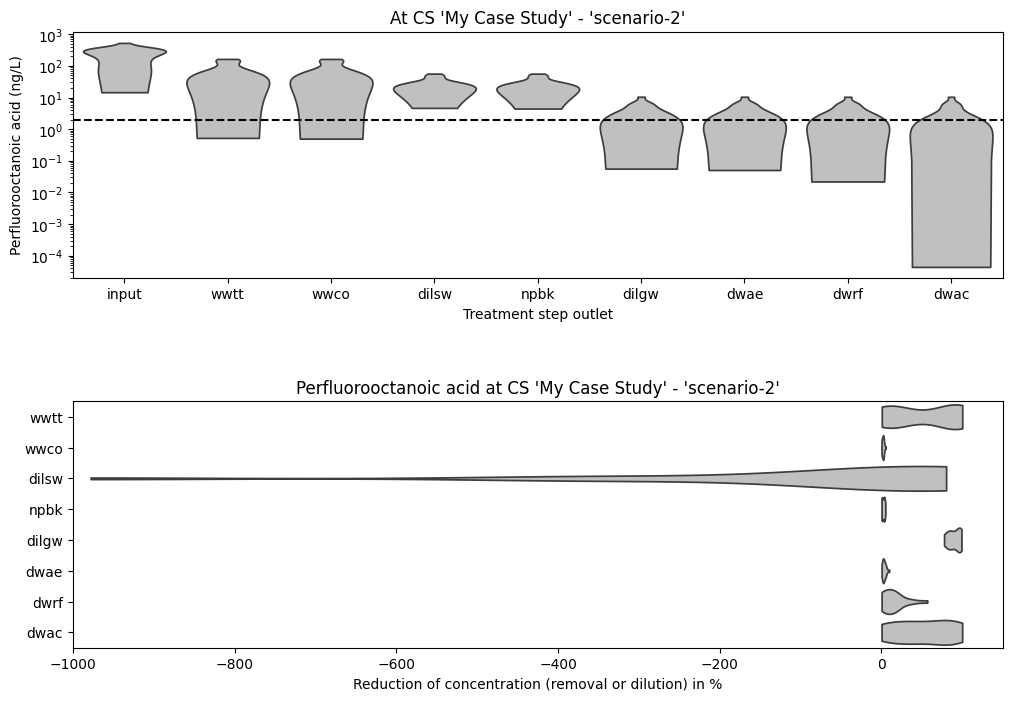

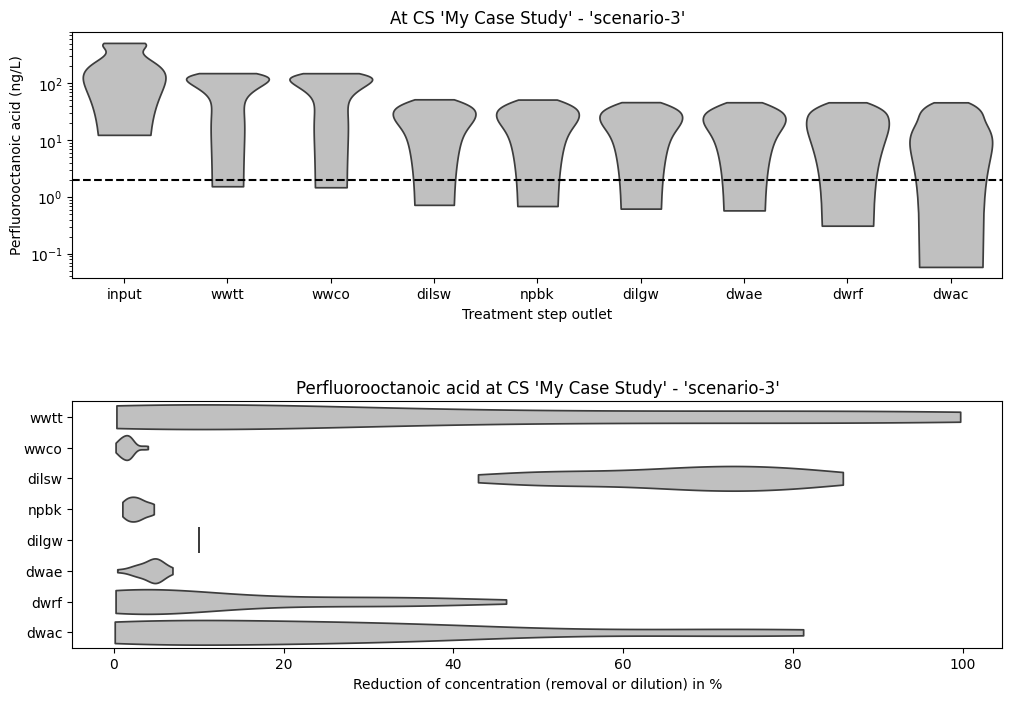

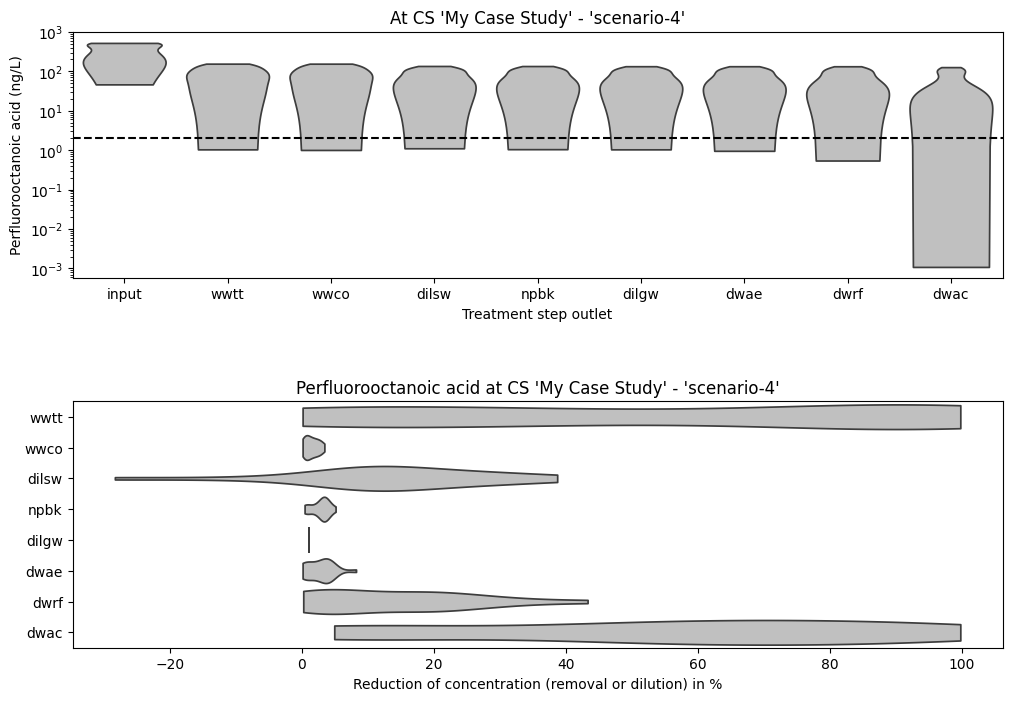

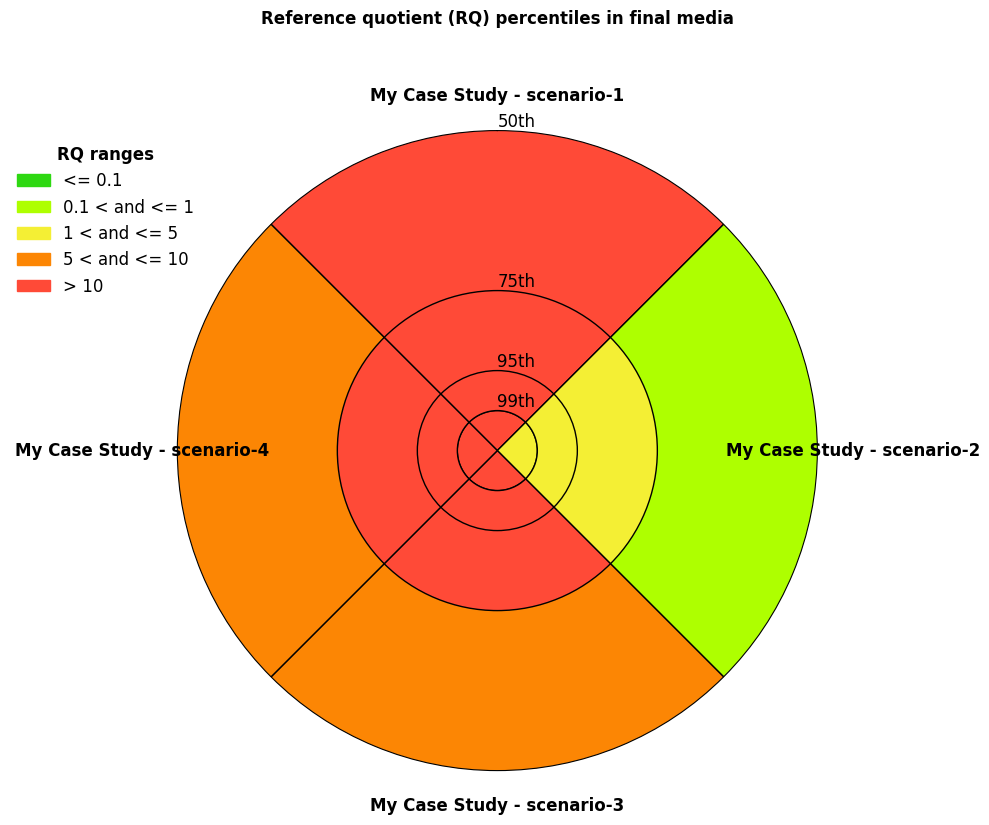

In [3]:
my_case_study = CaseStudy(
    name="My Case Study",
    mixtures=[
        Mixture(0, 0, 0, 0, Treatments.dilgw, Substances.pfoa, scenario="scenario-1"),
        Mixture(1, .1, 0, 0, Treatments.dilgw, Substances.pfoa, scenario="scenario-2"),
        Mixture(.1, 0, 0, 0, Treatments.dilgw, Substances.pfoa, scenario="scenario-3"),
        Mixture(.01, 0, 0, 0, Treatments.dilgw, Substances.pfoa, scenario="scenario-4"),
        Mixture(0.7, 0.1, 0, 0, Treatments.dilsw, Substances.pfoa, scenario="scenario-1"),
        Mixture(0.7, 0.1, 10, 3, Treatments.dilsw, Substances.pfoa, scenario="scenario-2"),
        Mixture(0.7, 0.1, np.log(10), np.log(3), Treatments.dilsw, Substances.pfoa, log_dist=True, scenario="scenario-3"),
        Mixture(0.7, 0.1, np.log(10), 0, Treatments.dilsw, Substances.pfoa, log_dist=True, scenario="scenario-4"),
    ],
    removal_percents=[
        RemovalPercent(np.array([1, 2, 3, 4]), Treatments.wwco, Substances.pfoa),
        RemovalPercent(np.array([10, 20, 30, 40]), Treatments.dwae, Substances.pfoa),
    ],
    references=[
        Reference("ref-1234", # the reference id
                  Substances.pfoa, Matrices.drw,
                  ref_value_ng_l=2.0,
                  year=2021,
                  comments="just an example")
    ],
    starting_concentration=[
        StartingConcentration(
            np.array([100., 300., 500.]), Substances.pfoa, Matrices.grw
        )]
)

substance = Substances.pfoa
input_matrix = Matrices.rww

start_c = StartingConcentration(
    np.array([100]),
    substance, matrix
)

treatment_train = TreatmentTrain([
    Treatments.wwtt,
    Treatments.wwco,
    Treatments.dilsw,
    Treatments.npbk,
    Treatments.dilgw,
    Treatments.dwae,
    Treatments.dwrf,
    Treatments.dwac,
])

all_results = []
for scenario in ["scenario-1", "scenario-2", "scenario-3", "scenario-4"]:
    result = simulate_removal(
        treatment_train,
        substance,
        input_matrix,
        n_runs = 20,
        rmv_factor_resolution = 1000,
        case_study=my_case_study,
        scenario=scenario
    )
    fig = er_profiles(result)
    result.export_excel(scenario + ".xlsx")
    all_results += [result]

spider_plot(all_results)
None

In [17]:
all_results[0].rmv_factor_df

,wwtt,wwco,dilsw,npbk,dilgw,dwae,dwrf,dwac
0,0.3,0.1,69.958859,0.2,0.0,1.6,0.3,0.3
1,0.8,0.3,73.895495,0.2,0.0,1.9,1.1,26.2
2,9.3,0.6,69.032437,0.9,0.0,2.2,3.5,63.4
3,22.8,0.7,53.232973,1.8,0.0,3.7,7.2,63.7
4,29.6,0.7,72.780156,1.8,0.0,4.2,8.4,63.9
5,66.8,0.8,76.554702,3.1,0.0,4.5,11.7,89.5
6,75.7,1.6,83.329298,3.1,0.0,4.7,24.0,92.0
7,82.3,2.2,69.666522,3.1,0.0,4.9,24.2,94.2
8,94.5,2.5,81.506814,4.5,0.0,5.0,24.5,98.4
9,99.9,2.5,68.016938,5.3,0.0,5.3,25.2,99.0
